<a href="https://colab.research.google.com/github/lukaszbibrzycki/AI/blob/main/amplitude_kl_LBMP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import numpy as np

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
nps = 1000
eps=0.00000001

In [ ]:
def dsdOmega(s,costh):
    cos2th=2*costh**2-1.
    return np.sqrt((s-1.16208)*(s-0.636804))/(((s-1.51782)**2 + 0.0218567) *(s-0.879844)*s)*(0.0555758-0.0295838*cos2th )

In [ ]:
z1points = np.linspace(1.16208, 2.4, nps)
z2points = np.linspace(-1, 1, nps)
(z1, z2) = np.meshgrid(z1points, z2points)
zgrid = np.concatenate((z1.reshape(-1, 1), z2.reshape(-1, 1)), axis=1)

In [ ]:
dsdOmegaSum = 0.0
for i in range(nps*nps):
    dsdOmegaSum = dsdOmegaSum + dsdOmega(zgrid[i][0], zgrid[i][1])

In [ ]:
dsdOmegaConst = dsdOmegaSum/(nps*nps)
dsdOmegaConst

0.5058018098289679

In [ ]:
def dsdOmegaNorm(s,costh):
    cos2th=2.*costh**2-1.
    return np.sqrt((s-1.16208)*(s-0.636804))/(((s-1.51782)**2 + 0.0218567) *(s-0.879844)*s)*(0.0555758-0.0295838*cos2th)/dsdOmegaConst
      

In [ ]:
def RejectionSampling2d(f,xrange,yrange,sample_count):
    bins=400
    xdel=(xrange[1]-xrange[0])/bins
    ydel=(yrange[1]-yrange[0])/bins
    x=np.array([xrange[0]+i*xdel/2. for i in range(bins)])
    y=np.array([yrange[0]+i*ydel/2. for i in range(bins)])
    valmesh=np.zeros((bins,bins))
    valmesh=f(x,y)
    maxfun = valmesh.max()

    count=0
    sample=[]
    rng=np.random.default_rng()
    while(count<sample_count):
        xval,yval,fval=rng.uniform((xrange[0],yrange[0],0),(xrange[1],yrange[1],maxfun))
        if(fval<=f(xval,yval)):
            sample.append([xval,yval])
            count+=1
    return np.array(sample)

In [ ]:
n = 1000000
smin=1.16208
smax=2.4
xrange = [1.16208, 2.4]
yrange = [-1, 1]
data = RejectionSampling2d(dsdOmega, xrange, yrange, n)
np.savetxt("/content/drive/MyDrive/Colab Notebooks/scosth-events.csv",data,delimiter=";")

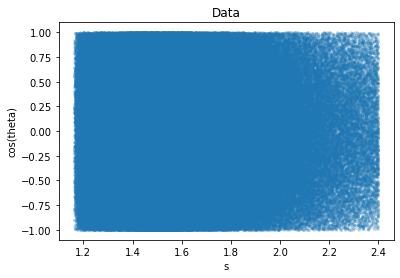

In [ ]:
plt.plot(data[:, 0], data[:, 1], ".", alpha=0.2, markeredgewidth=0.0)
plt.xlabel('s')
plt.ylabel('cos(theta)')
plt.title("Data")
plt.show()

In [ ]:
y = np.log(dsdOmega(data[:, 0], data[:, 1]))

In [ ]:
np.random.seed(0)
tf.random.set_seed(0)


tfd = tfp.distributions
tfb = tfp.bijectors

In [ ]:
ndim = 2

In [ ]:
zdist = tfd.MultivariateNormalDiag(loc=[0.0] * ndim)
zdist

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

In [ ]:
num_layers = 8
my_bijects = []
# loop over desired bijectors and put into list
for i in range(num_layers):
    # Syntax to make a MAF
    anet = tfb.AutoregressiveNetwork(
        params=ndim, hidden_units=[256, 256], activation="elu", kernel_regularizer=tf.keras.regularizers.l2(0.0001), bias_regularizer=tf.keras.regularizers.l2(0.0001)
    )
    ab = tfb.MaskedAutoregressiveFlow(anet)
    # Add bijector to list
    my_bijects.append(ab)
    # Now permuate (!important!)
    permute = tfb.Permute([1, 0])
    my_bijects.append(permute)
# put all bijectors into one "chain bijector"
# that looks like one
big_bijector = tfb.Chain(my_bijects)
# make transformed dist
td = tfd.TransformedDistribution(zdist, bijector=big_bijector)

In [ ]:
# declare the feature dimension
x = tf.keras.Input(shape=(2,), dtype=tf.float32)
# create a "placeholder" function
# that will be model output
log_prob = td.log_prob(x)
# use input (feature) and output (log prob)
# to make model
model = tf.keras.Model(x, log_prob)
# define a loss
def neg_loglik(yhat, log_prob):
    # losses always take in label, prediction
    # in keras. We do not have labels,
    # but we still need to accept the arg
    # to comply with Keras format
    return -log_prob

def pdf_loss(y, log_prob):
    return tf.square(log_prob - y)

# def pdf_kl(y, log_prob):
#     prob_y = tf.math.exp(y)
#     prob = tf.math.exp(log_prob)
    
#     return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(prob, prob_y))

def pdf_kl(y, log_prob):
    prob_y = tf.math.exp(y)
    prob = tf.math.exp(log_prob)
    
    return prob_y*(y - log_prob)

# original
# def pdf_kl_loglik(y, log_prob):
#     prob_y = tf.math.exp(y)
# #     prob = tf.math.exp(log_prob)
    
#     return prob_y*(y - log_prob) - log_prob #check this !!! should be prob ?

def pdf_kl_loglik(y, log_prob):
    prob_y = tf.math.exp(y)
    prob = tf.math.exp(log_prob)
    
    return prob_y*(y - log_prob) - prob_y+prob


# now we prepare model for training
model.compile(optimizer=tf.optimizers.Adam(1e-4), loss=pdf_kl_loglik)

In [ ]:
result = model.fit(data, y, epochs=100, batch_size = 1024, verbose=1)
model.save("/content/drive/MyDrive/Colab Notebooks/nfmodel")
plt.plot(result.history["loss"])
plt.show()

Epoch 1/100
192/977 [====>.........................] - ETA: 2:36 - loss: 0.7189

KeyboardInterrupt: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


40000
0


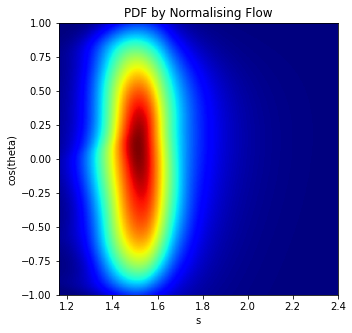

In [ ]:
z1points = np.linspace(1.16208, 2.4, 200)
z2points = np.linspace(-1, 1, 200)
(z1, z2) = np.meshgrid(z1points, z2points)
zgrid = np.concatenate((z1.reshape(-1, 1), z2.reshape(-1, 1)), axis=1)
p = np.exp(td.log_prob(zgrid))
print(p.size)
print(np.count_nonzero(np.isnan(p)))
# p = np.nan_to_num(p)
plt.figure(figsize = (5, 5))
# plt.imshow(
#     p.reshape(z1.shape), extent=[1.16208, 2.4, -1, 1]
# )
plt.imshow(p.reshape(z1.shape), extent=[1.16208, 2.4, -1, 1], aspect='auto', cmap = "jet")
plt.title("PDF by Normalising Flow")
plt.xlabel("s")
plt.ylabel("cos(theta)")
plt.show()

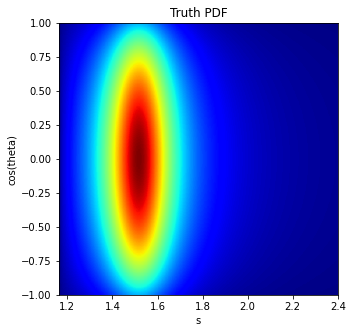

In [ ]:
truth = dsdOmegaNorm(z1, z2)
plt.figure(figsize = (5, 5))
plt.imshow(truth, extent=[1.16208, 2.4, -1, 1], aspect='auto', cmap = 'jet')
plt.title("Truth PDF")
plt.xlabel("s")
plt.ylabel("cos(theta)")
plt.show()

Text(0.5, 1.0, 'sampling')

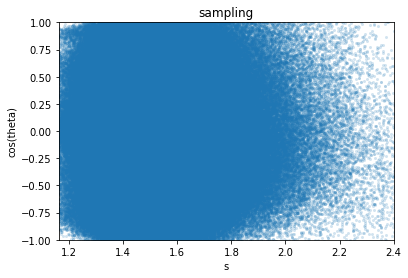

In [ ]:
zsamples = td.sample(n)
plt.plot(zsamples[:, 0], zsamples[:, 1],  ".", alpha=0.2, markeredgewidth=0.0)
plt.xlim(1.16208, 2.4)
plt.ylim(-1, 1)
plt.xlabel('s')
plt.ylabel('cos(theta)')
plt.title("sampling")
# plt.gca().set_aspect("equal")

In [ ]:
!pip install physt
import physt
from physt.histogram_nd import Histogram2D
from physt import h2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
nfdata_cut=[]
for i in range(zsamples.shape[0]):
  if zsamples[i,0]>=smin and zsamples[i,0]<=smax and zsamples[i,1]>=-1 and zsamples[i,1]<=1:
    nfdata_cut.append([zsamples[i,0],zsamples[i,1]])



In [ ]:
nfdata_cut=np.array(nfdata_cut)
histm = h2(data[:,0],data[:,1],[30,30],name="Model",axis_names=["s",r"$cos\theta$"])
histnf = h2(nfdata_cut[:,0], nfdata_cut[:,1],[30,30],name="Normalizing flow",axis_names=["s",r"$cos\theta$"]) 

In [ ]:
zsamples.shape[0]-nfdata_cut.shape[0]

22749

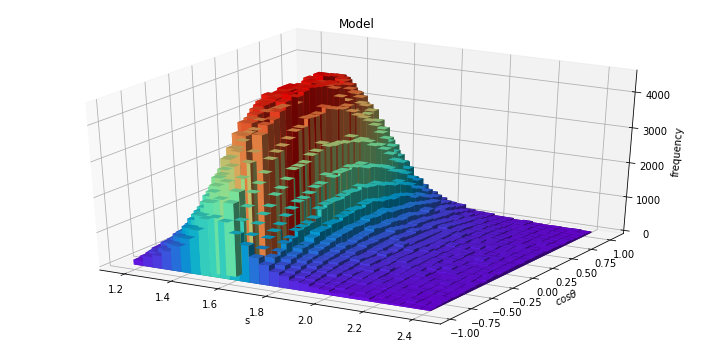

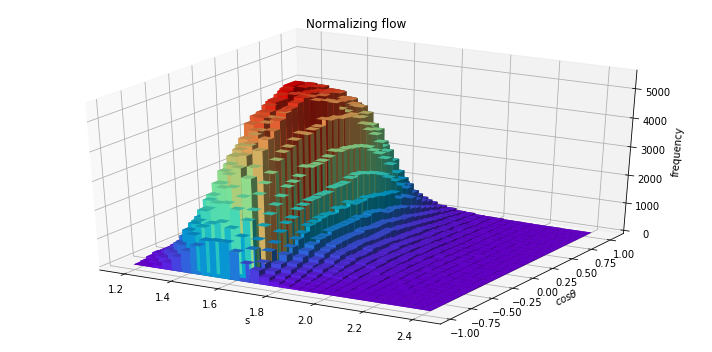

In [ ]:
histm.plot("bar3d", cmap="rainbow",figsize=(10,5))
histnf.plot("bar3d", cmap="rainbow",figsize=(10,5))
plt.show()

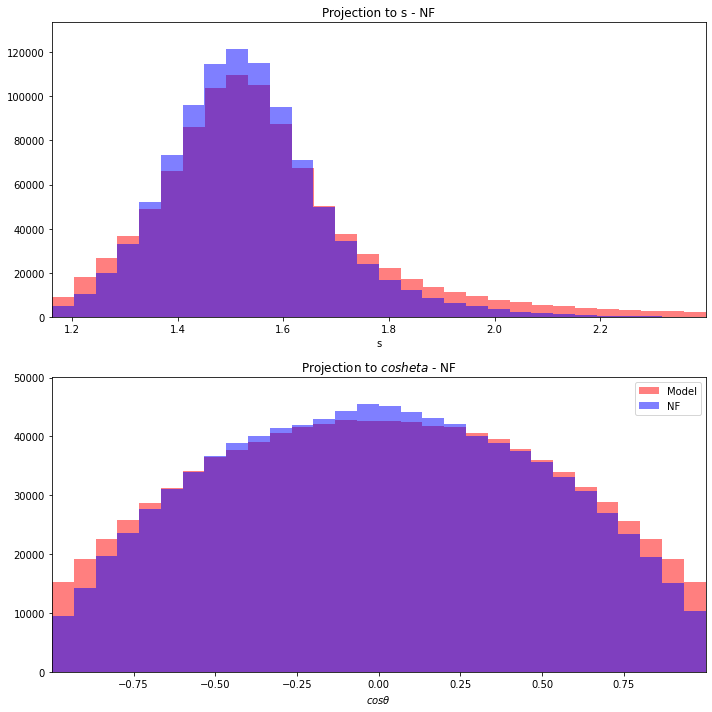

In [ ]:
projm_s = histm.projection("s", name="Projection to s - MODEL")
projm_costh = histm.projection(r"$cos\theta$", name="Projection to $cos\theta$ - MODEL")

projnf_s = histnf.projection("s", name="Projection to s - NF")
projnf_costh = histnf.projection(r"$cos\theta$", name="Projection to $cos\theta$ - NF")

fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(10, 10))

projm_s.plot(ax=ax1,color="red",label="Model",alpha=.5)
projnf_s.plot(ax=ax1,color="blue",label="NF",alpha=.5)
projm_costh.plot(ax=ax2,color="red",label="Model",alpha=.5)
projnf_costh.plot(ax=ax2,color="blue",label="NF",alpha=.5)
plt.legend()
plt.show()

NameError: ignored

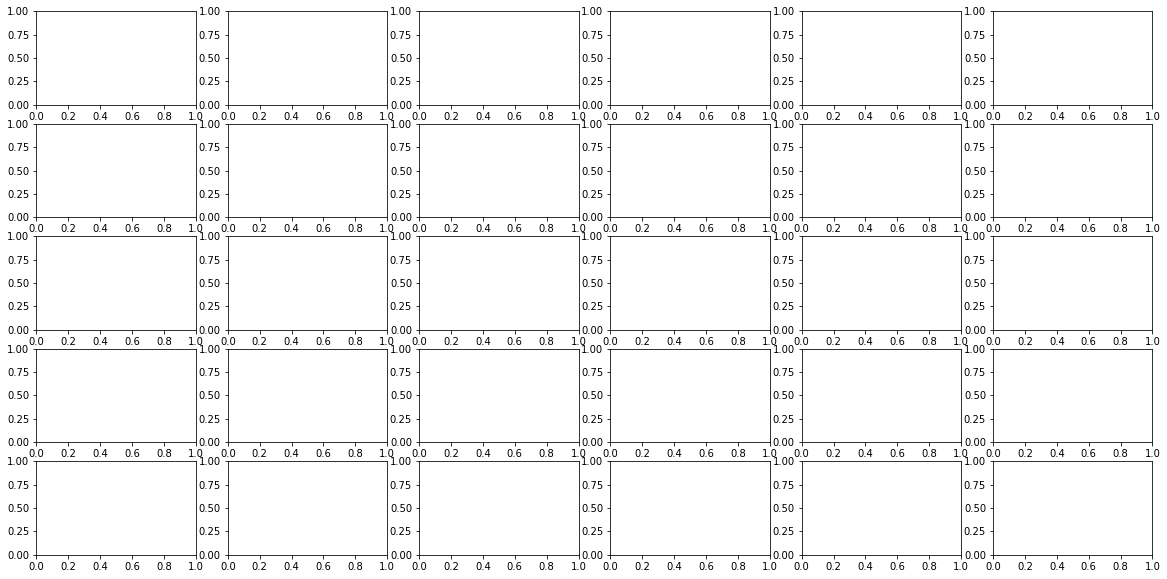

In [ ]:
from matplotlib import pyplot as plt
c=6
r=5
fig, axs = plt.subplots(r, c, figsize=(20, 10))
counter=0
for i in range(r):
  for j in range(c):
    projm_s = histm.select("s", index=counter)
    projnf_s = histnf.select("s", index=counter)
    projm_s.plot(ax=axs[i,j],color="red",label="Model",alpha=.5,)
    projnf_s.plot(ax=axs[i,j],color="blue",label="NF",alpha=.5)
    counter+=1
plt.legend()
plt.show()

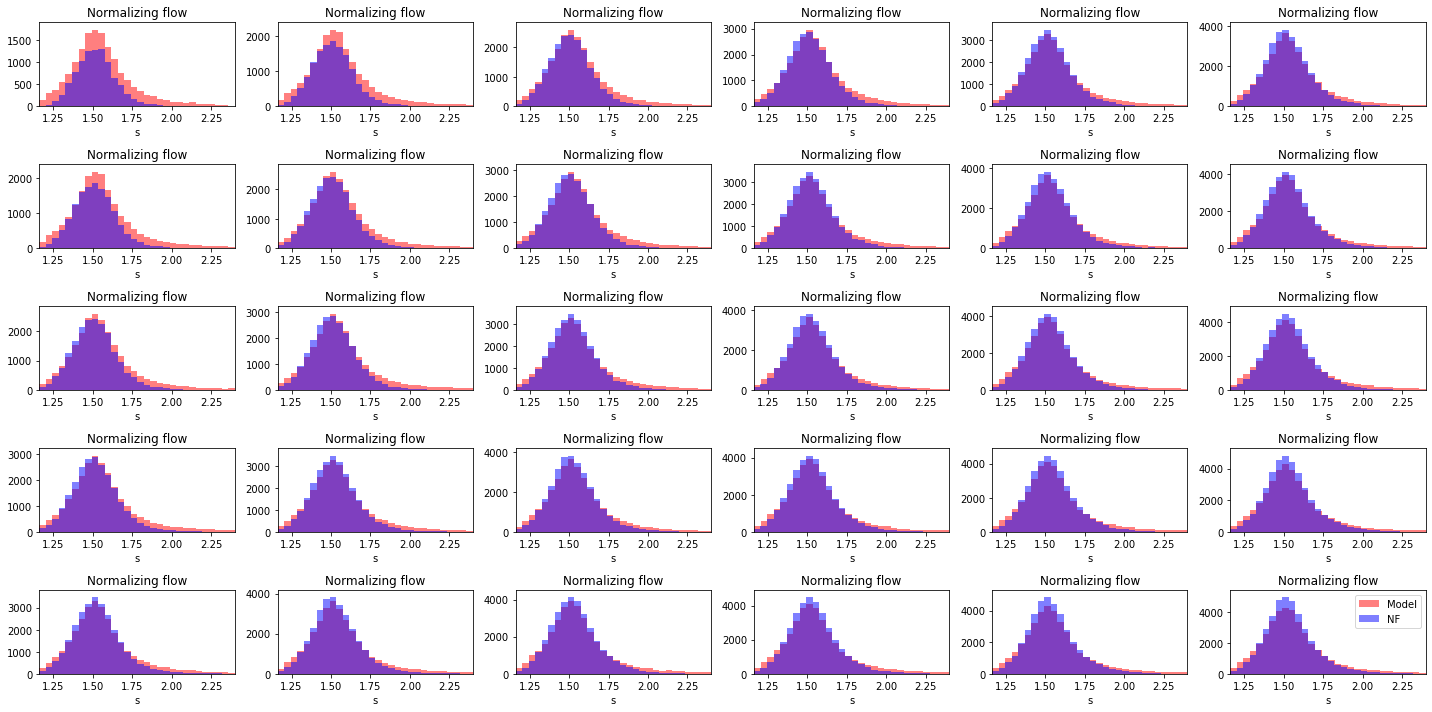

In [ ]:
c=6
r=5
fig, axs = plt.subplots(r, c, figsize=(20, 10))
for i in range(r):
  for j in range(c):
    projm_s = histm.select(r"$cos\theta$", index=i+j)
    projnf_s = histnf.select(r"$cos\theta$", index=i+j)
    projm_s.plot(ax=axs[i,j],color="red",label="Model",alpha=.5,)
    projnf_s.plot(ax=axs[i,j],color="blue",label="NF",alpha=.5)
plt.legend()
plt.show()

In [ ]:
import scipy
scipy.special.kl_div( p.reshape((200,200))[:,1:],truth[:,1:], out=None).sum()

10085.53823058277

In [ ]:
import numpy as np

def KL(P,Q):
  """ Epsilon is used here to avoid conditional code for
  checking that neither P nor Q is equal to 0. """     
  epsilon = 0.00001     
  # You may want to instead make copies to avoid changing the np arrays.     
  P = P+epsilon
  Q = Q+epsilon

  divergence = np.sum(P*np.log(P/Q)-P+Q)
  return divergence

Epoch 1/300
977/977 [==============================] - 10s 10ms/step - loss: 0.0271
Epoch 2/300
977/977 [==============================] - 9s 9ms/step - loss: 0.0270
Epoch 3/300
977/977 [==============================] - 9s 9ms/step - loss: 0.0270
Epoch 4/300
977/977 [==============================] - 9s 9ms/step - loss: 0.0269
Epoch 5/300
977/977 [==============================] - 10s 10ms/step - loss: 0.0269
Epoch 6/300
977/977 [==============================] - 9s 9ms/step - loss: 0.0269
Epoch 7/300
977/977 [==============================] - 9s 9ms/step - loss: 0.0268
Epoch 8/300
977/977 [==============================] - 9s 9ms/step - loss: 0.0268
Epoch 9/300
977/977 [==============================] - 9s 9ms/step - loss: 0.0267
Epoch 10/300
977/977 [==============================] - 9s 9ms/step - loss: 0.0267
Epoch 11/300
977/977 [==============================] - 9s 9ms/step - loss: 0.0267
Epoch 12/300
977/977 [==============================] - 9s 9ms/step - loss: 0.0266
Epoch 13/

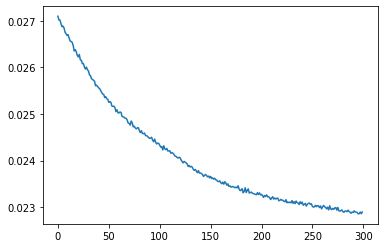

In [ ]:
result = model.fit(data, y, epochs=300, batch_size = 1024, verbose=1)
plt.plot(result.history["loss"])
plt.show()

40000
0


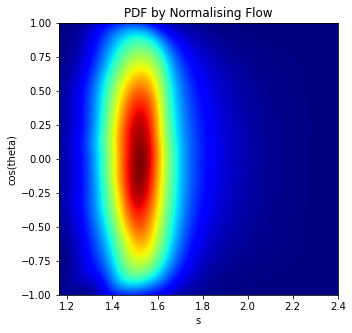

In [ ]:
z1points = np.linspace(1.16208, 2.4, 200)
z2points = np.linspace(-1, 1, 200)
(z1, z2) = np.meshgrid(z1points, z2points)
zgrid = np.concatenate((z1.reshape(-1, 1), z2.reshape(-1, 1)), axis=1)
p = np.exp(td.log_prob(zgrid))
print(p.size)
print(np.count_nonzero(np.isnan(p)))
# p = np.nan_to_num(p)
plt.figure(figsize = (5, 5))
# plt.imshow(
#     p.reshape(z1.shape), extent=[1.16208, 2.4, -1, 1]
# )
plt.imshow(p.reshape(z1.shape), extent=[1.16208, 2.4, -1, 1], aspect='auto', cmap = "jet")
plt.title("PDF by Normalising Flow")
plt.xlabel("s")
plt.ylabel("cos(theta)")
plt.show()